#Define HMM and model's parameters
Transition matrix:
<table>
  <tr>
    <th></th>
    <th>Rainy</th>
    <th>Sunny</th>
  </tr>
  <tr>
    <th>Rainy</th>
    <td>0.7</td>
    <td>0.3</td>
  </tr>
  <tr>
    <th>Sunny</th>
    <td>0.4</td>
    <td>0.6</td>
  </tr>
</table>
Observation matrix:
<table>
  <tr>
    <th></th>
    <th>walk</th>
    <th>shop</th>
    <th>clean</th>
  </tr>
  <tr>
    <th>Rainy</th>
    <td>0.1</td>
    <td>0.4</td>
    <td>0.5</td>
  </tr>
  <tr>
    <th>Sunny</th>
    <td>0.6</td>
    <td>0.3</td>
    <td>0.1</td>
  </tr>
</table>
States = ('Rainy': 0, 'Sunny': 1)

Observation sequence = ('walk': 0, 'shop': 1, 'clean': 2)

Start probability = {'Rainy': 0.6, 'Sunny': 0.4}

In [1]:
import math
import time
from tqdm.auto import trange, tqdm
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

class HMM:
    def __init__(self):
        self.transition_matrix = np.array([[0.7, 0.3],
                                           [0.4, 0.6]]) 
        self.observation_matrix = np.array([[0.1, 0.4, 0.5], 
                                            [0.6, 0.3, 0.1]]) 
        self.prior = np.array([0.6, 0.4])
        self.observation_sequence = np.array([0, 1, 2])
        # #convert numpy array to tensor matrix
        # self.tensor_transition_matrix = tf.convert_to_tensor(self.transition_matrix)
        # self.tensor_observation_matrix = tf.convert_to_tensor(self.observation_matrix)
        # self.tensor_prior = tf.convert_to_tensor(self.prior)

#Implement algorithm 1 in the paper

In [2]:
#https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm
#compute forward probabilities
def potential_forward(model, Y):
    fwd = np.zeros((Y.shape[0], model.transition_matrix.shape[1]))
    #k = 1...T
    for k in range(len(Y)):
      if k == 0:
          #ψ1(x1) = p(y1 | x1)p(x1)
          #x1 ∼ p(x1) is a prior, xk ~ p(xk | xk−1) are transition probabilities, yk ∼ p(yk | xk) are observations
          psi_f = model.observation_matrix[:, Y[k]] * model.prior #equation (5a), step 2 in algorithm 1
      else:
          #ψk(xk−1, xk) = p(yk | xk)p(xk | xk−1)
          psi = model.observation_matrix[:, Y[k]] * model.transition_matrix #equation (5b), step 4 in algorithm 1
          psi_f = psi_f @ psi
      fwd[k] = psi_f
    return fwd

#compute backward probabilities
def potential_backward(model, Y):
    #psi_b = np.ones(psi_f.shape)
    #bwd = fwd.copy()
    psi_b = np.ones(model.prior.shape[0]) #step 7 in algorithm 1
    bwd = np.zeros((Y.shape[0], model.transition_matrix.shape[1]))
    bwd[-1] = psi_b
    for k in reversed(range(len(Y) - 1)):
        psi = model.observation_matrix[:, Y[k+1]] * model.transition_matrix #step 9 in algorithm 1
        psi_b = psi @ psi_b
        bwd[k] = psi_b
    return bwd

#compute posterior values
def potential_smoother(model, Y):
    psi_f = potential_forward(model, Y)
    psi_b = potential_backward(model, Y)
    posterior = []
    for f, b in zip(psi_f, psi_b):
      posterior.append((f*b)/np.sum(f*b))
    return posterior

fwd_bwd_psi_f = potential_forward(HMM(), HMM().observation_sequence)
fwd_bwd_psi_b = potential_backward(HMM(), HMM().observation_sequence)
fwd_bwd_psi = potential_smoother(HMM(), HMM().observation_sequence)
print('Forward')
print('Rain:', [fwd_bwd_psi_f[i][0] for i in range(len(fwd_bwd_psi_f))])
print('No rain:', [fwd_bwd_psi_f[i][1] for i in range(len(fwd_bwd_psi_f))])
print('\nBackward')
print('Rain:', [fwd_bwd_psi_b[i][0] for i in range(len(fwd_bwd_psi_b))])
print('No rain:', [fwd_bwd_psi_b[i][1] for i in range(len(fwd_bwd_psi_b))])
print('\nPosterior')
print('Rain:', [fwd_bwd_psi[i][0] for i in range(len(fwd_bwd_psi))])
print('No rain:', [fwd_bwd_psi[i][1] for i in range(len(fwd_bwd_psi))])

Forward
Rain: [0.06, 0.0552, 0.029039999999999996]
No rain: [0.24, 0.0486, 0.004572]

Backward
Rain: [0.1298, 0.38, 1.0]
No rain: [0.10760000000000002, 0.26, 1.0]

Posterior
Rain: [0.23170296322741876, 0.6240628347018922, 0.8639771510174937]
No rain: [0.7682970367725812, 0.3759371652981078, 0.13602284898250624]


#Implement tf-based algorithm 1 in the paper

In [3]:
#compute forward probabilities
def potential_forward_pass(model, observation_sequence):
  def forward_scan(carry, y):
      #carry is (0, HMM().prior), y is the iteration
      k, p = carry 
      if k == 0:
        p = model.observation_matrix[:, y] * p
      else:
        psi = model.observation_matrix[:, y] * model.transition_matrix
        p = np.matmul(p, psi)
      return k+1, p
  k, psi_f = tf.scan(forward_scan, observation_sequence, (0, model.prior), swap_memory=True)
  return psi_f

#compute backward probabilities
def potential_backward_pass(model, observation_sequence):
  def backward_scan(carry, y):
      #carry is psi_b_end
      p = carry
      psi = model.observation_matrix[:, y] * model.transition_matrix 
      p = np.matmul(psi, p)
      return p
  psi_b_end = np.ones(model.prior.shape[0])
  psi_b_rest = tf.scan(backward_scan, observation_sequence[1:], psi_b_end, reverse=True, swap_memory=True)
  psi_b = tf.concat([psi_b_rest, tf.expand_dims(psi_b_end, 0)], 0)
  return psi_b

#compute posterior values
def potential_smoother(model, observation_sequence):
    psi_f = potential_forward_pass(model, observation_sequence)
    psi_b = potential_backward_pass(model, observation_sequence)
    return (psi_f*psi_b)/tf.reduce_sum(psi_f*psi_b, axis=-1, keepdims=True)

psi_f = potential_forward_pass(HMM(), HMM().observation_sequence)
psi_b = potential_backward_pass(HMM(), HMM().observation_sequence)
potential_ss = potential_smoother(HMM(), HMM().observation_sequence)
tf.print('Forward')
tf.print('Rain:', [psi_f[i][0] for i in range(len(psi_f))])
tf.print('No rain:', [psi_f[i][1] for i in range(len(psi_f))])
tf.print('\nBackward')
tf.print('Rain:', [psi_b[i][0] for i in range(len(psi_b))])
tf.print('No rain:', [psi_b[i][1] for i in range(len(psi_b))])
tf.print('\nPosterior')
tf.print('Rain:', [potential_ss[i][0] for i in range(len(potential_ss))])
tf.print('No rain:', [potential_ss[i][1] for i in range(len(potential_ss))])

Forward
Rain: [0.06, 0.0552, 0.029039999999999996]
No rain: [0.24, 0.0486, 0.004572]

Backward
Rain: [0.1298, 0.38, 1]
No rain: [0.10760000000000002, 0.26, 1]

Posterior
Rain: [0.23170296322741876, 0.62406283470189217, 0.86397715101749373]
No rain: [0.76829703677258121, 0.37593716529810778, 0.13602284898250624]


In [4]:
print('Difference between forward pass of tf-based and classical:', np.abs(psi_f - fwd_bwd_psi_f).max())
print('Difference between backward pass of tf-based and classical:', np.abs(psi_b - fwd_bwd_psi_b).max())
print('Difference between smoothing pass of tf-based and classical:', np.abs(potential_ss - fwd_bwd_psi).max())

Difference between forward pass of tf-based and classical: 0.0
Difference between backward pass of tf-based and classical: 0.0
Difference between smoothing pass of tf-based and classical: 0.0


#Generate data

In [6]:
def catrnd(rng, p):
    if p.ndim > 1: p = p.squeeze()
    return rng.choice(p.shape[0], size=1,  p=p) 

#X: array of unobserved states, Y: array of observed states
def simulate_data(model, steps, seed=1):
    rng = np.random.default_rng(seed)
    X = np.zeros((steps, 1))
    Y = np.zeros(steps, dtype=np.int32)
    x = catrnd(rng, model.prior)
    for k in range(steps):
        if k > 0:
            x = catrnd(rng, model.transition_matrix[x]) #min: 0.0, max: 1.0
        y = catrnd(rng, model.observation_matrix[x]) #min: 0.0, max: 2.0
        X[k] = x
        Y[k] = y
    return X, Y

#Compare unobserved states from generated data with guess states from HMM

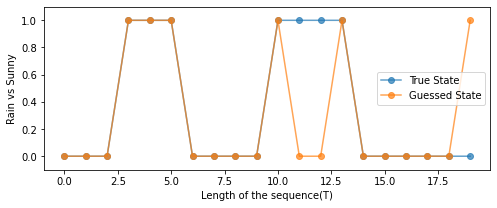

In [7]:
cmp_true_states, cmp_obs_states = simulate_data(model=HMM(), steps=20)
cmp_psi = potential_smoother(HMM(), cmp_obs_states)

res_obs = []
for i in range(len(cmp_psi)):
    if cmp_psi[i][0] > cmp_psi[i][1]:
      res_obs.append(0) #rain
    else: 
      res_obs.append(1) #sunny

convert_true_states = sum(cmp_true_states.tolist(), [])
convert_true_states = [int(x) for x in convert_true_states]

plt.figure(figsize=(8, 3))
plt.plot(convert_true_states, '-o', alpha=0.7)
plt.plot(res_obs, '-o', alpha=0.7)
plt.legend(('True State','Guessed State'), loc = 'right')
plt.ylim(-0.1, 1.1)
plt.xlabel('Length of the sequence(T)')
plt.ylabel('Rain vs Sunny')
plt.draw()

#Implement algorithm 2 in the paper

In [ ]:
!pip install --upgrade tbb

In [10]:
import numba

#https://cs.wmich.edu/gupta/teaching/cs5260/5260Sp15web/lectureNotes/thm14%20-%20parallel%20prefix%20from%20Ottman.pdf
#if >= 2d array, final prefix sum = up sweep pass
@numba.jit(nopython=True, parallel=True)
def numba_prefix_sum(arr, iteration, shape_arr, log_n):
    #save the input
    bi = np.copy(arr)
    #up sweep
    for d in range(log_n):
        for i in range(0, iteration, 2**(d + 1)):
            #bi[i + 2**(d + 1) - 1] = bi[i + 2**d - 1] + bi[i + 2**(d + 1) - 1]
            bi[i + 2**(d + 1) - 1] += bi[i + 2**d - 1]
    bi[iteration - 1] = 0
    #down sweep
    for d in range(log_n - 1, -1, -1):
        for i in range(0, iteration, 2**(d + 1)):
            temp = bi[i + 2**d - 1]
            bi[i + 2**d - 1] = bi[i + 2**(d + 1) - 1] #left child
            bi[i + 2**(d + 1) - 1] = temp + bi[i + 2**(d + 1) - 1] #right child 
    #final pass
    bi += arr
    return bi

def sequential_prefix_sum(arr):
    if type(arr) == 'list':
        arr = np.array(arr)
    for i in range(len(arr) - 1):
        arr[i + 1] += arr[i]
    return arr

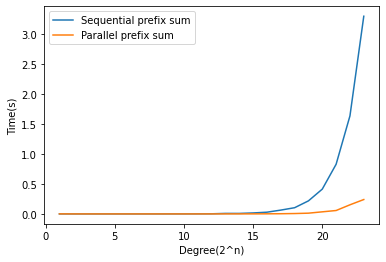

In [12]:
from time import time

time_squential_prefix_sum = []
time_parallel_prefix_sum = []

for i in list(range(1, 24)):
    seq_list = np.random.randint(100, size=pow(2, i))
    input_arr_parallel = np.array(seq_list)
    iter = input_arr_parallel.shape[0]
    shape_arr_parallel = input_arr_parallel.shape
    log_n_parallel = np.log2(iter).astype(int)

    t = time()
    seq_list = sequential_prefix_sum(seq_list)
    t_new = time() - t
    time_squential_prefix_sum.append(t_new)

    t = time()
    par_list = numba_prefix_sum(input_arr_parallel, iter, shape_arr_parallel, log_n_parallel)
    t_new = time() - t
    time_parallel_prefix_sum.append(t_new)

plt.plot(list(range(1, 24)), time_squential_prefix_sum)
plt.plot(list(range(1, 24)), time_parallel_prefix_sum)
plt.xlabel('Degree(2^n)')
plt.ylabel('Time(s)')
plt.legend(['Sequential prefix sum','Parallel prefix sum'])
#plt.savefig("cmp_time_prefix_sum.svg")
plt.show()

#Implement algorithm 3 in the paper

In [13]:
#parallel forward pass
def parallel_forward_potential_init_first(model, y):
    psi = tf.multiply(model.observation_matrix[:, y], model.prior)
    psi = tf.tile(tf.expand_dims(psi, axis=0), [model.prior.shape[0], 1])
    return psi

def parallel_forward_potential_init_rest(model, y):
    tmp = tf.gather(tf.transpose(model.observation_matrix), y, axis=0) #get all rows of observation_matrix with y index
    psi = tf.expand_dims(tmp, 1) * tf.expand_dims(model.transition_matrix, 0) #step 2 in algo 4
    return psi

def parallel_forward_potential_init(model, y):
    first_elem = parallel_forward_potential_init_first(model, y[0]) #case k = 0
    rest_elems = parallel_forward_potential_init_rest(model, y[1:]) #case k > 0
    a0k = tf.concat([tf.expand_dims(first_elem, 0), rest_elems], axis=0) #concat a0:1 vs ak-1:k to get a0k
    return a0k

def parallel_forward_potential(model, y, max_parallel=100000):
    a0k = parallel_forward_potential_init(model, y) 
    psi = tfp.math.scan_associative(lambda aij, ajk: aij @ ajk, a0k, max_num_levels=math.ceil(math.log2(max_parallel))) #step 4 in algo 4
    return psi[:, 0]

'''
def sequential_prefix_sum(operator_parallel, arr):
    size_arr = len(arr) - 1
    if type(arr) == 'list':
        arr = np.array(arr)
    if operator_parallel == '@':
      for i in range(len(arr)-1):
          arr[i - size_arr] = arr[i] @ arr[i - size_arr]
    else:
      for i in range(len(arr)-1):
          arr[i + 1] += arr[i]
    return arr

sequential_prefix_sum('@', np.array(parallel_forward_potential_init(HMM(), HMM().observation_sequence)))[:, 0]
'''

parallel_forward_potential(HMM(), HMM().observation_sequence)

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.06    , 0.24    ],
       [0.0552  , 0.0486  ],
       [0.02904 , 0.004572]])>

In [14]:
#parallel backward pass
def parallel_backward_potential_init_last(model):
    psi = tf.ones_like(model.transition_matrix) #step 7 in algorithm 1
    return psi

def parallel_backward_potential_init_rest(model, y):
    tmp = tf.gather(tf.transpose(model.observation_matrix), y, axis=0) #get all rows of observation_matrix with y index
    psi = tf.expand_dims(tmp, 1) * tf.expand_dims(model.transition_matrix, 0) #step 9 in algorithm 1
    return psi

def parallel_backward_potential_init(model, y):
    last_elem = parallel_backward_potential_init_last(model)
    rest_elems = parallel_backward_potential_init_rest(model, y[1:])
    akT = tf.concat([rest_elems, tf.expand_dims(last_elem, 0)], axis=0) 
    return akT

def parallel_backward_potential(model, y,  max_parallel=100000):
    initial_elements = parallel_backward_potential_init(model, y)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    #last_elem = rest_elems @ last_elem -> ajk @ aij because rest_elems concat last_elem
    final_elements = tfp.math.scan_associative(lambda aij, ajk: ajk @ aij, reversed_elements, max_num_levels=math.ceil(math.log2(max_parallel)))
    final_elements = tf.reverse(final_elements, axis=[0])
    return final_elements[:, :, 0]
parallel_backward_potential(HMM(), HMM().observation_sequence)

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.1298, 0.1076],
       [0.38  , 0.26  ],
       [1.    , 1.    ]])>

In [15]:
#parallel forward-backward
def parallel_potential_smoother(model, y, max_parallel=100000):
    psi_f = parallel_forward_potential(model, y, max_parallel)
    psi_b = parallel_backward_potential(model, y, max_parallel)
    return (psi_f*psi_b)/tf.reduce_sum(psi_f*psi_b, axis=1, keepdims=True) #equation (22)
parallel_potential_smoother(HMM(), HMM().observation_sequence)

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.23170296, 0.76829704],
       [0.62406283, 0.37593717],
       [0.86397715, 0.13602285]])>

In [16]:
with tf.device('/CPU:0'):
    psi_f = parallel_forward_potential(HMM(), HMM().observation_sequence, max_parallel=100000)
    print('Difference between classical and parallel forward potentials:', np.abs(psi_f - fwd_bwd_psi_f).max())
    psi_b = parallel_backward_potential(HMM(), HMM().observation_sequence, max_parallel=100000)
    print('Difference between classical and parallel backward potentials:', np.abs(psi_b - fwd_bwd_psi_b).max())
    potential_ss = parallel_potential_smoother(HMM(), HMM().observation_sequence, max_parallel=100000)
    print('Difference between classical and parallel smoothers:', np.abs(potential_ss - fwd_bwd_psi).max())

Difference between classical and parallel forward potentials: 6.938893903907228e-18
Difference between classical and parallel backward potentials: 0.0
Difference between classical and parallel smoothers: 1.1102230246251565e-16


#Run algorithm 3 with the example in the slide

In [17]:
class HMM_example_algo3:
    def __init__(self):
        self.transition_matrix = np.array([[0.65, 0.35],
                                           [0.75, 0.25]]) 
        self.observation_matrix = np.array([[0.2, 0.8], 
                                            [0.3, 0.7]]) 
        self.prior = np.array([0.5, 0.5])
        self.observation_sequence = np.array([0, 1])
print('Forward pass:', parallel_forward_potential(HMM_example_algo3(), HMM_example_algo3().observation_sequence, max_parallel=100000))
print('Backward pass:', parallel_backward_potential(HMM_example_algo3(), HMM_example_algo3().observation_sequence, max_parallel=100000))
print('Potential smoother:', parallel_potential_smoother(HMM_example_algo3(), HMM_example_algo3().observation_sequence))

Forward pass: tf.Tensor(
[[0.1     0.15   ]
 [0.142   0.05075]], shape=(2, 2), dtype=float64)
Backward pass: tf.Tensor(
[[0.765 0.775]
 [1.    1.   ]], shape=(2, 2), dtype=float64)
Potential smoother: tf.Tensor(
[[0.39688716 0.60311284]
 [0.73670558 0.26329442]], shape=(2, 2), dtype=float64)


#Compare time between parallel algorithm 3 and classical algorithm 1

Iter 1
Compare forward of classical algo 1 and parallel algo 3: 4.336808689942018e-19
Compare backward of classical algo 1 and parallel algo 3: 8.673617379884035e-19
Compare posterior of classical algo 1 and parallel algo 3: 1.1102230246251565e-16
Iter 2
Compare forward of classical algo 1 and parallel algo 3: 4.336808689942018e-19
Compare backward of classical algo 1 and parallel algo 3: 8.673617379884035e-19
Compare posterior of classical algo 1 and parallel algo 3: 2.220446049250313e-16
Iter 3
Compare forward of classical algo 1 and parallel algo 3: 4.336808689942018e-19
Compare backward of classical algo 1 and parallel algo 3: 1.3877787807814457e-17
Compare posterior of classical algo 1 and parallel algo 3: nan
Iter 4
Compare forward of classical algo 1 and parallel algo 3: 4.336808689942018e-19
Compare backward of classical algo 1 and parallel algo 3: 6.938893903907228e-18
Compare posterior of classical algo 1 and parallel algo 3: nan
Iter 5
Compare forward of classical algo 1 and

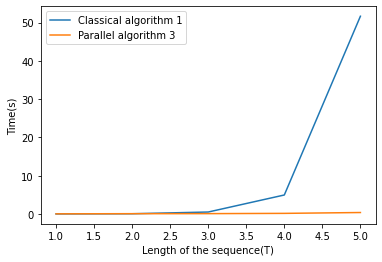

In [19]:
import matplotlib.pyplot as plt
from time import time

time_classical_algo1 = []
time_parallel_algo3 = []
for i in list(range(1, 6)):
    un_obs_arr, obs_arr = simulate_data(model=HMM(), steps=10**i)
    #time classical algo 1
    t = time()
    tmp1 = potential_forward(HMM(), obs_arr)
    tmp2 = potential_backward(HMM(), obs_arr)
    tmp3 = potential_smoother(HMM(), obs_arr)
    t_new = time() - t
    time_classical_algo1.append(t_new)
    #time parallel algo 3
    t = time()
    tmp4 = parallel_forward_potential(HMM(), obs_arr)
    tmp5 = parallel_backward_potential(HMM(), obs_arr)
    tmp6 = parallel_potential_smoother(HMM(), obs_arr)
    t_new = time() - t
    time_parallel_algo3.append(t_new)
    #compare res
    print('Iter', i)
    print('Compare forward of classical algo 1 and parallel algo 3:', np.abs(tmp1-tmp4).max())
    print('Compare backward of classical algo 1 and parallel algo 3:', np.abs(tmp2-tmp5).max())
    print('Compare posterior of classical algo 1 and parallel algo 3:', np.abs(tmp3-tmp6).max())

plt.plot(list(range(1, 6)), time_classical_algo1)
plt.plot(list(range(1, 6)), time_parallel_algo3)
plt.xlabel('Length of the sequence(T)')
plt.ylabel('Time(s)')
plt.legend(['Classical algorithm 1','Parallel algorithm 3'])
plt.show()

#Implement algorithm 4 in the paper

In [20]:
def classical_viterbi(model, y):
    """
    Parameters
    ----------
    xmap: MAP path
    V_list: probabilities of most probable paths
    u_list: most probable path sequence
    """
    V_list = np.zeros((model.transition_matrix.shape[0], len(y)))
    u_list = np.zeros((model.transition_matrix.shape[0], len(y)))
    #forward step
    V_list[:, 0] =  model.observation_matrix[:, y[0]] * model.prior #k = 1 -> V1(x1) = ψ1(x1), equation (28) and step 2 in algo 4
    u_list[:, 0] = 0
    for k in range(1, len(y)):
        psi = model.observation_matrix[np.newaxis, :, y[k]].T * model.transition_matrix.T
        V_list[:, k] = np.max(V_list[:, k - 1] * psi, 1)
        u_list[:, k] = np.argmax(V_list[:, k - 1] * model.transition_matrix.T, 1)
    V_list = V_list.T
    u_list = u_list.T
    xmap = np.zeros(len(y), dtype=int)
    xmap[-1] = np.argmax(V_list[-1])
    #backward step
    for k in reversed(range(len(y) - 1)):
        xmap[k] = u_list[k + 1, xmap[k + 1]]
    return xmap, V_list, u_list
xmap, v_list, u_list = classical_viterbi(HMM(), HMM().observation_sequence)
print(str(xmap) + '\n')
print(str(v_list) + '\n')
print(u_list)

[1 0 0]

[[0.06     0.24    ]
 [0.0384   0.0432  ]
 [0.01344  0.002592]]

[[0. 0.]
 [1. 1.]
 [0. 1.]]


#Run algorithm 4 with the example in the slide

In [21]:
class HMM_example_algo4:
    def __init__(self):
        self.transition_matrix = np.array([[0.6, 0.4],
                                           [0.8, 0.2]]) 
        self.observation_matrix = np.array([[0.9, 0.1], 
                                            [0.3, 0.7]]) 
        self.prior = np.array([0.5, 0.5])
        self.observation_sequence = np.array([0, 1])
xmap_example_algo4, v_list_example_algo4, u_list_example_algo4 = classical_viterbi(HMM_example_algo4(), HMM_example_algo4().observation_sequence)
print(str(xmap_example_algo4) + '\n')
print(str(v_list_example_algo4) + '\n')
print(u_list_example_algo4)

[0 1]

[[0.45  0.15 ]
 [0.027 0.126]]

[[0. 0.]
 [0. 0.]]


#Compare algorithm 4 with generated data

In [22]:
X_algo4, Y_algo4 = simulate_data(model=HMM(), steps=30)
classical_xmap, classical_V_list, classical_u_list = classical_viterbi(HMM(), Y_algo4)

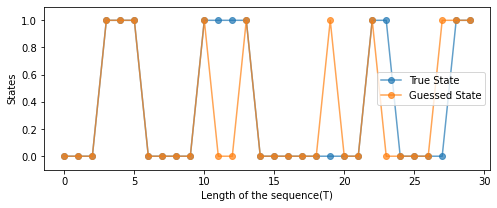

In [23]:
plt.figure(figsize=(8, 3))
plt.plot(X_algo4, '-o', alpha=0.7)
plt.plot(classical_xmap, '-o', alpha=0.7)
plt.legend(('True State','Guessed State'), loc = 'right')
plt.ylim(-0.1, 1.1)
plt.xlabel('Length of the sequence(T)')
plt.ylabel('States')
plt.draw()

#Implement parallel algorithm 5 in the paper

In [24]:
#parallel backward viterbi 
def parallel_forward_viterbi_init_first(model, y):
    psi = tf.multiply(model.observation_matrix[:, y], model.prior)
    psi = tf.tile(tf.expand_dims(psi, axis=0), [model.prior.shape[0], 1])
    return psi

def parallel_forward_viterbi_init_rest(model, y):
    tmp = tf.gather(tf.transpose(model.observation_matrix), y, axis=0) #get all rows of observation_matrix with y index
    psi = tf.expand_dims(tmp, 1) * tf.expand_dims(model.transition_matrix, 0) #step 2 in algo 4
    return psi

def parallel_forward_viterbi_init(model, y):
    first_elem = parallel_forward_viterbi_init_first(model, y[0]) #case k = 0
    rest_elems = parallel_forward_viterbi_init_rest(model, y[1:]) #case k > 0
    a0k = tf.concat([tf.expand_dims(first_elem, 0), rest_elems], axis=0) #concat a0:1 vs ak-1:k to get a0k
    return a0k

def parallel_forward_viterbi(model, y, max_parallel=100000):
    a0k = parallel_forward_viterbi_init(model, y) 
    #step 4 in algo 4 and equation (42)
    psi = tfp.math.scan_associative(lambda aij, ajk: tf.reduce_max(tf.expand_dims(aij, -1) * tf.expand_dims(ajk, 1), axis=2), a0k, max_num_levels=math.ceil(math.log2(max_parallel))) 
    return psi[:, 0]

tf.print(parallel_forward_viterbi(HMM(), HMM().observation_sequence))

[[0.06 0.24]
 [0.038400000000000004 0.043199999999999995]
 [0.01344 0.0025919999999999997]]


In [25]:
#parallel forward viterbi
def parallel_backward_viterbi_init_last(model):
    psi = tf.ones_like(model.transition_matrix) #step 7 in algorithm 1
    return psi

def parallel_backward_viterbi_init_rest(model, y):
    tmp = tf.gather(tf.transpose(model.observation_matrix), y, axis=0) #get all rows of observation_matrix with y index
    psi = tf.expand_dims(tmp, 1) * tf.expand_dims(model.transition_matrix, 0) #step 9 in algorithm 1
    return psi

def parallel_backward_viterbi_init(model, y):
    last_elem = parallel_backward_viterbi_init_last(model)
    rest_elems = parallel_backward_viterbi_init_rest(model, y[1:])
    akT = tf.concat([rest_elems, tf.expand_dims(last_elem, 0)], axis=0) 
    return akT

def parallel_backward_viterbi(model, y,  max_parallel=100000):
    initial_elements = parallel_backward_viterbi_init(model, y)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    final_elements = tfp.math.scan_associative(lambda aij, ajk: tf.reduce_max(tf.expand_dims(aij, 1) * tf.expand_dims(ajk, -1), axis=2), 
                                               reversed_elements, max_num_levels=math.ceil(math.log2(max_parallel)))
    final_elements = tf.reverse(final_elements, axis=[0])
    return final_elements[:, :, 0]

tf.print(parallel_backward_viterbi(HMM(), HMM().observation_sequence))

[[0.09799999999999999 0.056000000000000008]
 [0.35 0.2]
 [1 1]]


In [26]:
#parallel forward-backward viterbi
def parallel_potential_viterbi(model, y, max_parallel=100000):
    vlist = parallel_forward_viterbi(model, y, max_parallel)
    wlist = parallel_backward_viterbi(model, y, max_parallel)
    xmap = tf.squeeze(tf.math.argmax(vlist * wlist, axis=1))
    return xmap

tf.print(parallel_potential_viterbi(HMM(), HMM().observation_sequence))

[1 0 0]


In [27]:
with tf.device('/CPU:0'):
    xmap_parallel = parallel_potential_viterbi(HMM(), Y_algo4, max_parallel=100000)
    vlist_parallel = parallel_forward_viterbi(HMM(), Y_algo4)
    print('Different xmap between parallel and classical viterbi: ', np.abs(xmap_parallel - classical_xmap).max())
    print('Different Vlist between parallel and classical viterbi: ', np.abs(vlist_parallel - classical_V_list).max())

Different xmap between parallel and classical viterbi:  0
Different Vlist between parallel and classical viterbi:  1.3552527156068805e-20


#Run algorithm 5 with the example in the slide

In [28]:
print('xmap:', parallel_potential_viterbi(HMM_example_algo4(), HMM_example_algo4().observation_sequence, max_parallel=100000))
print('vlist:', parallel_forward_viterbi(HMM_example_algo4(), HMM_example_algo4().observation_sequence))

xmap: tf.Tensor([0 1], shape=(2,), dtype=int64)
vlist: tf.Tensor(
[[0.45  0.15 ]
 [0.027 0.126]], shape=(2, 2), dtype=float64)


#Implement classical viterbi algorithm 4 based on max-product

In [29]:
def max_product_viterbi(model, y):
    V_list = np.zeros((model.transition_matrix.shape[0], len(y)))
    #forward step
    V_list[:, 0] =  model.observation_matrix[:, y[0]] * model.prior #k = 1 -> V1(x1) = ψ1(x1), equation (28) and step 2 in algo 4
    for k in range(1, len(y)):
        psi = model.observation_matrix[np.newaxis, :, y[k]].T * model.transition_matrix.T
        V_list[:, k] = np.max(V_list[:, k - 1] * psi, 1)
    #backward step
    W_list = V_list.copy()
    W_list[:, -1] = np.ones(model.transition_matrix.shape[0])
    for k in reversed(range(len(y) - 1)):
        psi = model.observation_matrix[np.newaxis, :, y[k + 1]] * model.transition_matrix
        W_list[:, k] = np.max(W_list[:, k + 1] * psi, 1)
    V_list = V_list.T
    W_list = W_list.T
    xmap = [np.argmax(V_list[k] * W_list[k]) for k in range(len(y))]
    return xmap, V_list, W_list
max_product_xmap, max_product_vlist, max_product_wlist = max_product_viterbi(HMM(), HMM().observation_sequence)
print(str(max_product_xmap) + '\n')
print(str(max_product_vlist) + '\n')
print(max_product_wlist)

[1, 0, 0]

[[0.06     0.24    ]
 [0.0384   0.0432  ]
 [0.01344  0.002592]]

[[0.098 0.056]
 [0.35  0.2  ]
 [1.    1.   ]]


#Compare max-product viterbi with classical viterbi

In [30]:
cmp_max_product_xmap, cmp_max_product_vlist, cmp_max_product_wlist = max_product_viterbi(HMM(), Y_algo4)
print('Difference xmap between classical and max-product viterbi: ', max([abs(a - b) for a, b in zip(classical_xmap, cmp_max_product_xmap)]))
print('Difference vlist between classical and max-product viterbi: ', np.abs(classical_V_list, cmp_max_product_vlist).max())

Difference xmap between classical and max-product viterbi:  0
Difference vlist between classical and max-product viterbi:  0.3
